In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
from PIL import Image
from typing import *
from tinydb import TinyDB, Query

from pulp_frontnet.PyTorch.Frontnet.DataProcessor import DataProcessor
from pulp_frontnet.PyTorch.Frontnet.Dataset import Dataset
from pulp_frontnet.PyTorch.Frontnet.Frontnet import FrontnetModel
from pulp_frontnet.PyTorch.Frontnet import Utils
from pulp_frontnet.PyTorch.Frontnet.Utils import ModelManager
from pulp_frontnet.PyTorch.Frontnet.ModelTrainer import ModelTrainer

from patch_optimizers.utils import *
from patch_optimizers.sliding_window_optimizer import SlidingWindowOptimizer
from patch_optimizers.simulated_annealing_optimizer import SimulatedAnnealingOptimizer
from patch_optimizers.random_optimizer import RandomOptimizer
from patch_optimizers.genetic_optimizer import GeneticOptimizer
from patch_optimizers.optimizer_interface import Optimizer

In [2]:
testset_path = "pulp_frontnet/PyTorch/Data/Data/160x96StrangersTestset.pickle"
[x_test, y_test] = DataProcessor.ProcessTestData(testset_path)

trainset_path = "pulp_frontnet/PyTorch/Data/Data/160x96OthersTrainsetAug.pickle"
[x_train, y_train] = DataProcessor.ProcessTestData(trainset_path)


# Create the PyTorch data loaders
test_set = Dataset(x_test, y_test)
test_loader = data.DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=1)

# do not use training set as it's quality is too low (augmentations not applied on ground truth)

In [3]:
len(test_set)

4028

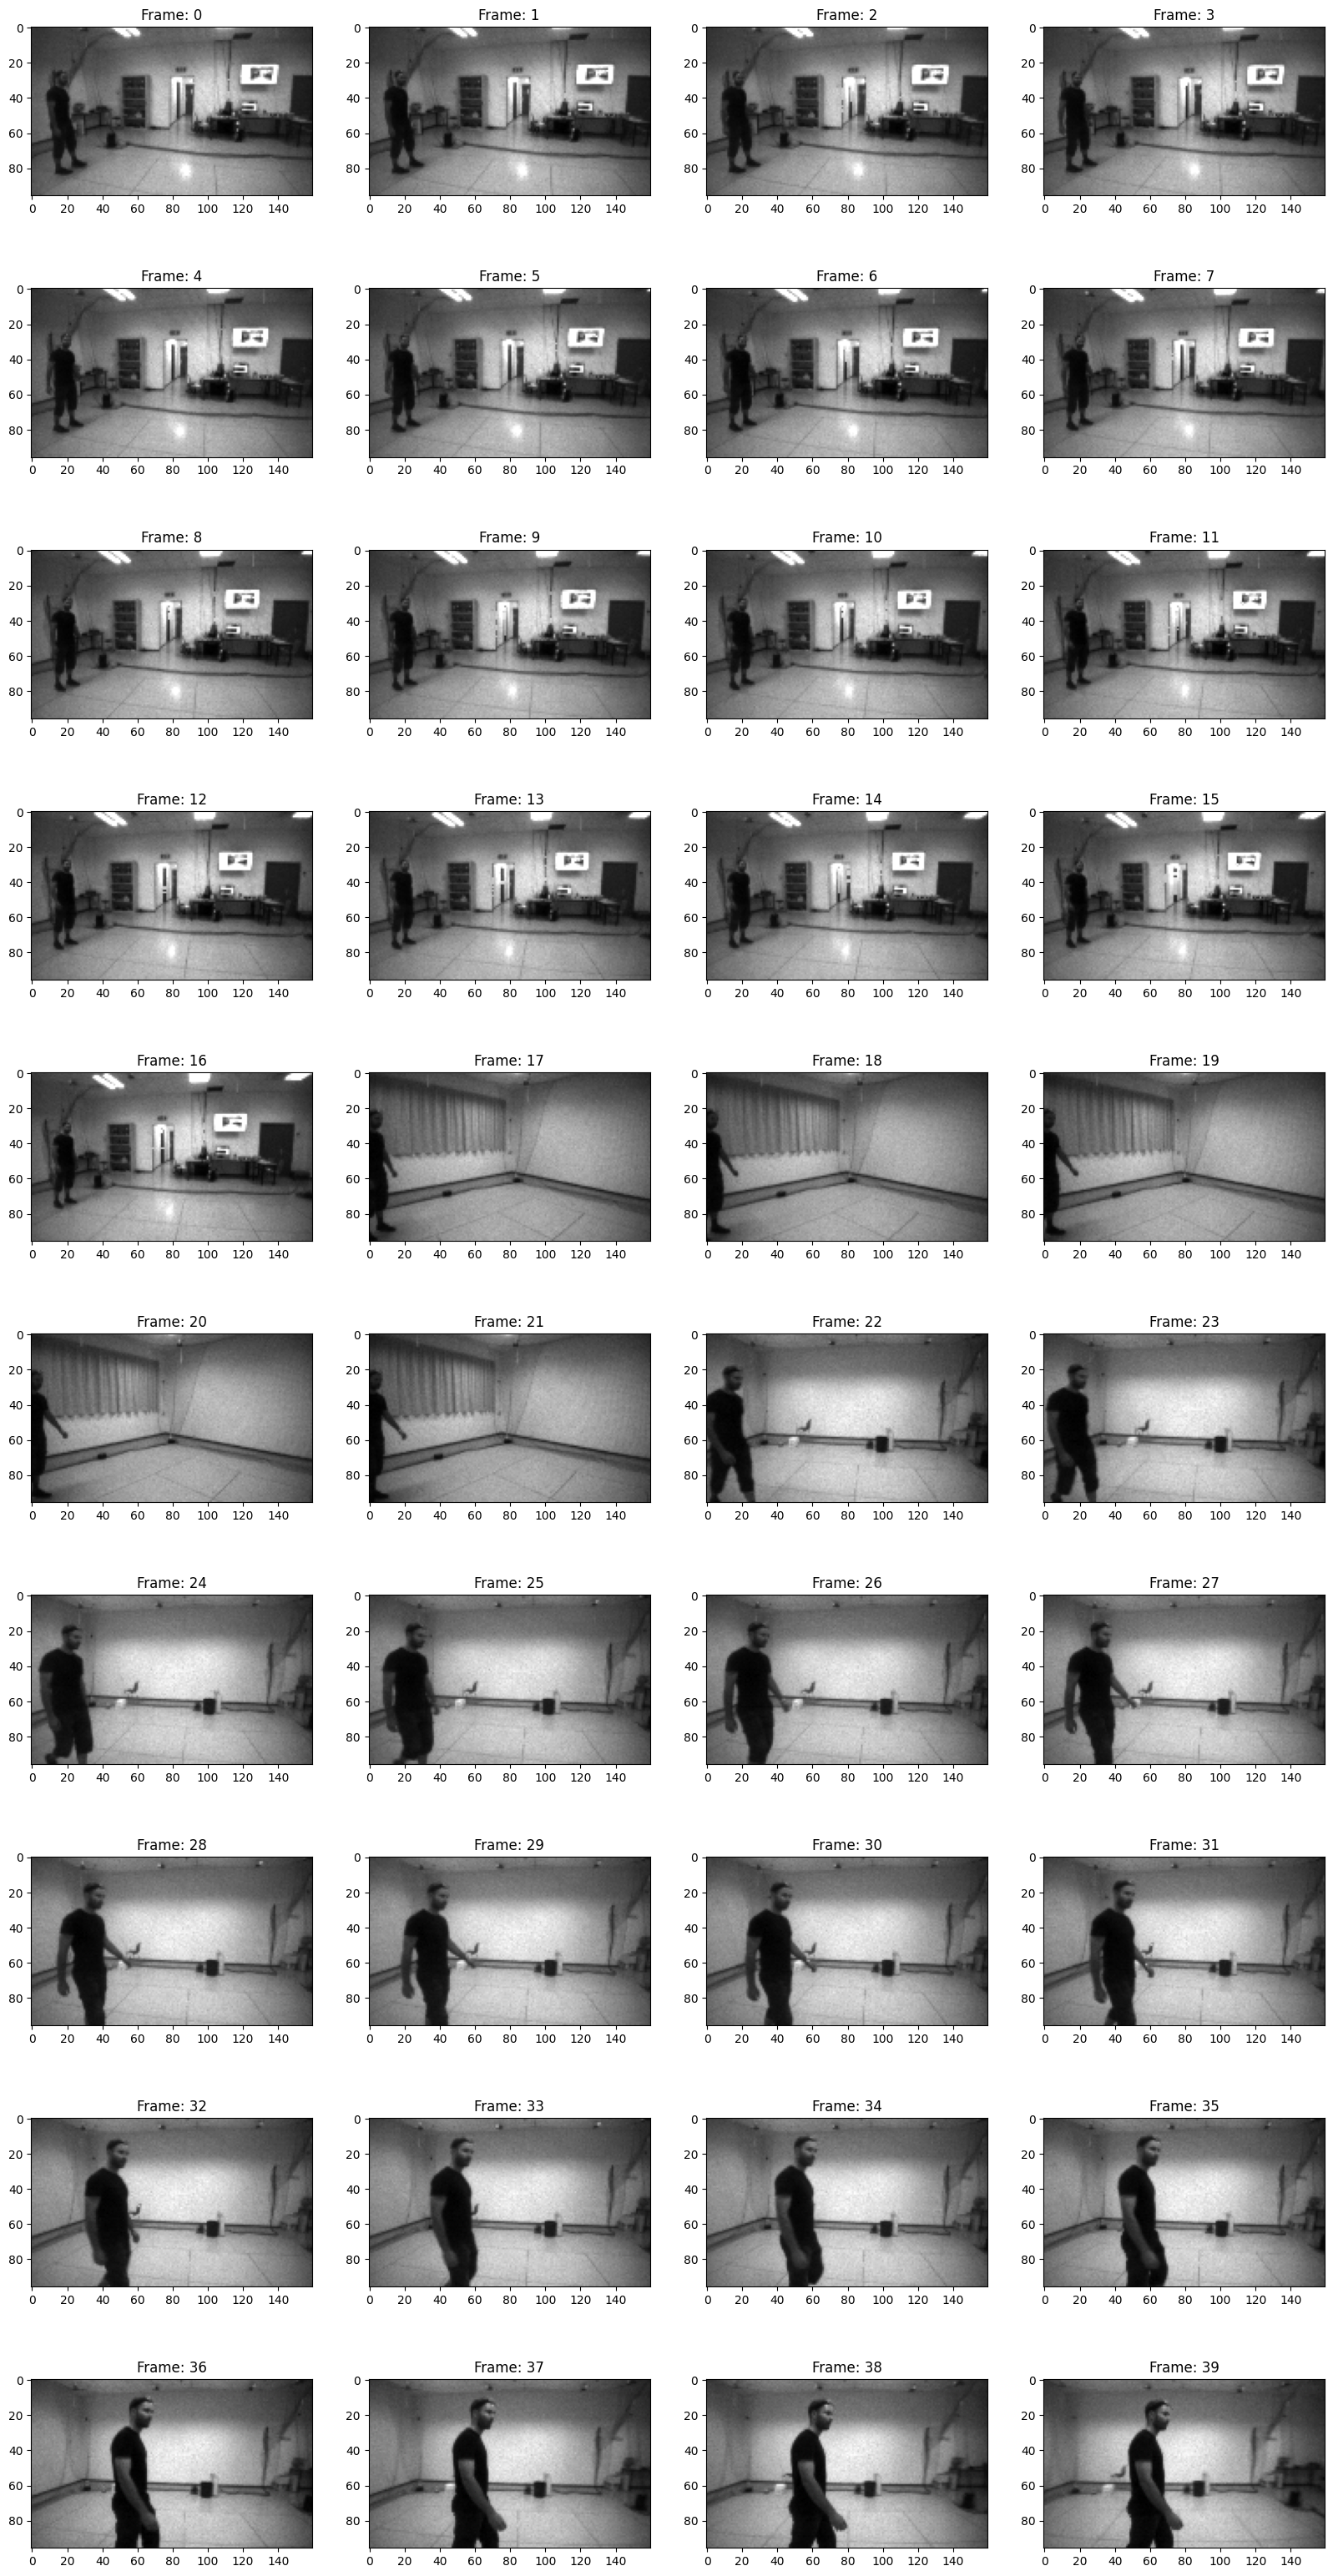

In [4]:
n_rows = 10
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 40))
for i, (x, y) in enumerate(test_set):
    axes[i // n_cols][i % n_cols].imshow(x[0], cmap="gray")
    axes[i // n_cols][i % n_cols].set_title(f"Frame: {i}")
    if i == n_cols * n_rows - 1:
        break
    

## Find optimal patches for each frame

In [5]:
model_path = "pulp_frontnet/PyTorch/Models/Frontnet160x32.pt"
model = FrontnetModel()
ModelManager.Read(model_path, model)
model.eval()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

Frontnet(
  (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ConvBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (layer2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [6]:
optimizer_factories: List[Callable[[], Optimizer]] = [
    lambda: RandomOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        n_dots_to_generate=1000,
        k_dots=1,
        dot_size=10,
    ),

    lambda: SlidingWindowOptimizer(
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        model=model,
        k_dots=1,
        dot_size=10,
        stride=5,
    ),

    lambda: SimulatedAnnealingOptimizer(
        x0=(80, 45),
        stride=10,
        max_iters=1000,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        debug=False,
    ),

    lambda: GeneticOptimizer(
        n_iters=20,
        population_size=100,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        max_x=160,
        max_y=96,
        dot_size=10,
        elitism=False,
        debug=False,
    ),
    
    lambda: GeneticOptimizer(
        n_iters=20,
        population_size=100,
        model=model,
        cost_f=lambda prediction, ground_truth: single_vector_element_cost_f(prediction, ground_truth, element_index=0),
        max_x=160,
        max_y=96,
        dot_size=10,
        elitism=True,
        debug=False,
    ), 
]

In [7]:
db = TinyDB('tiny_db.json')

### Run untargeted attack on x coordinate

In [10]:
for i, (x, y) in tqdm(enumerate(test_set), desc="Finding patches", total=len(test_set)):
    
    db_record = {
        "image_idx": i,
    }
    
    for optimizer_factory in optimizer_factories:
        optimizer = optimizer_factory()
        optimal_cost, optimal_patches = optimizer.run(
            img=x, ground_truth=y
        )
        if isinstance(optimal_patches, list):
            optimal_patches = optimal_patches[0]
        optimal_cost = float(optimal_cost)
        db_record[type(optimizer).__name__] = (optimal_cost, (int(optimal_patches[0]), int(optimal_patches[1])))

    
    db.insert(db_record)

Finding patches: 100%|██████████| 4028/4028 [11:05:37<00:00,  9.91s/it]  


In [134]:
User = Query()

db.search(User.image_idx == 4027)

[{'image_idx': 4027,
  'RandomOptimizer': [0.4775258004665375, [57, 48]],
  'SlidingWindowOptimizer': [0.4345712959766388, [55, 50]],
  'SimulatedAnnealingOptimizer': [0.5066872239112854, [56, 49]],
  'GeneticOptimizer': [0.5433875918388367, [55, 49]]}]

## Untargeted attack on x coordinate

In [30]:
test_set = list(test_set)

In [85]:
optimizer_names = [
    "RandomOptimizer", "SlidingWindowOptimizer", "SimulatedAnnealingOptimizer", "GeneticOptimizer", "GeneticOptimizerElitism"
]

In [87]:
genetic_elitism_db = TinyDB("genetic_elitism_x.json")

Checking patches:   0%|          | 20/4028 [00:00<02:35, 25.79it/s] 


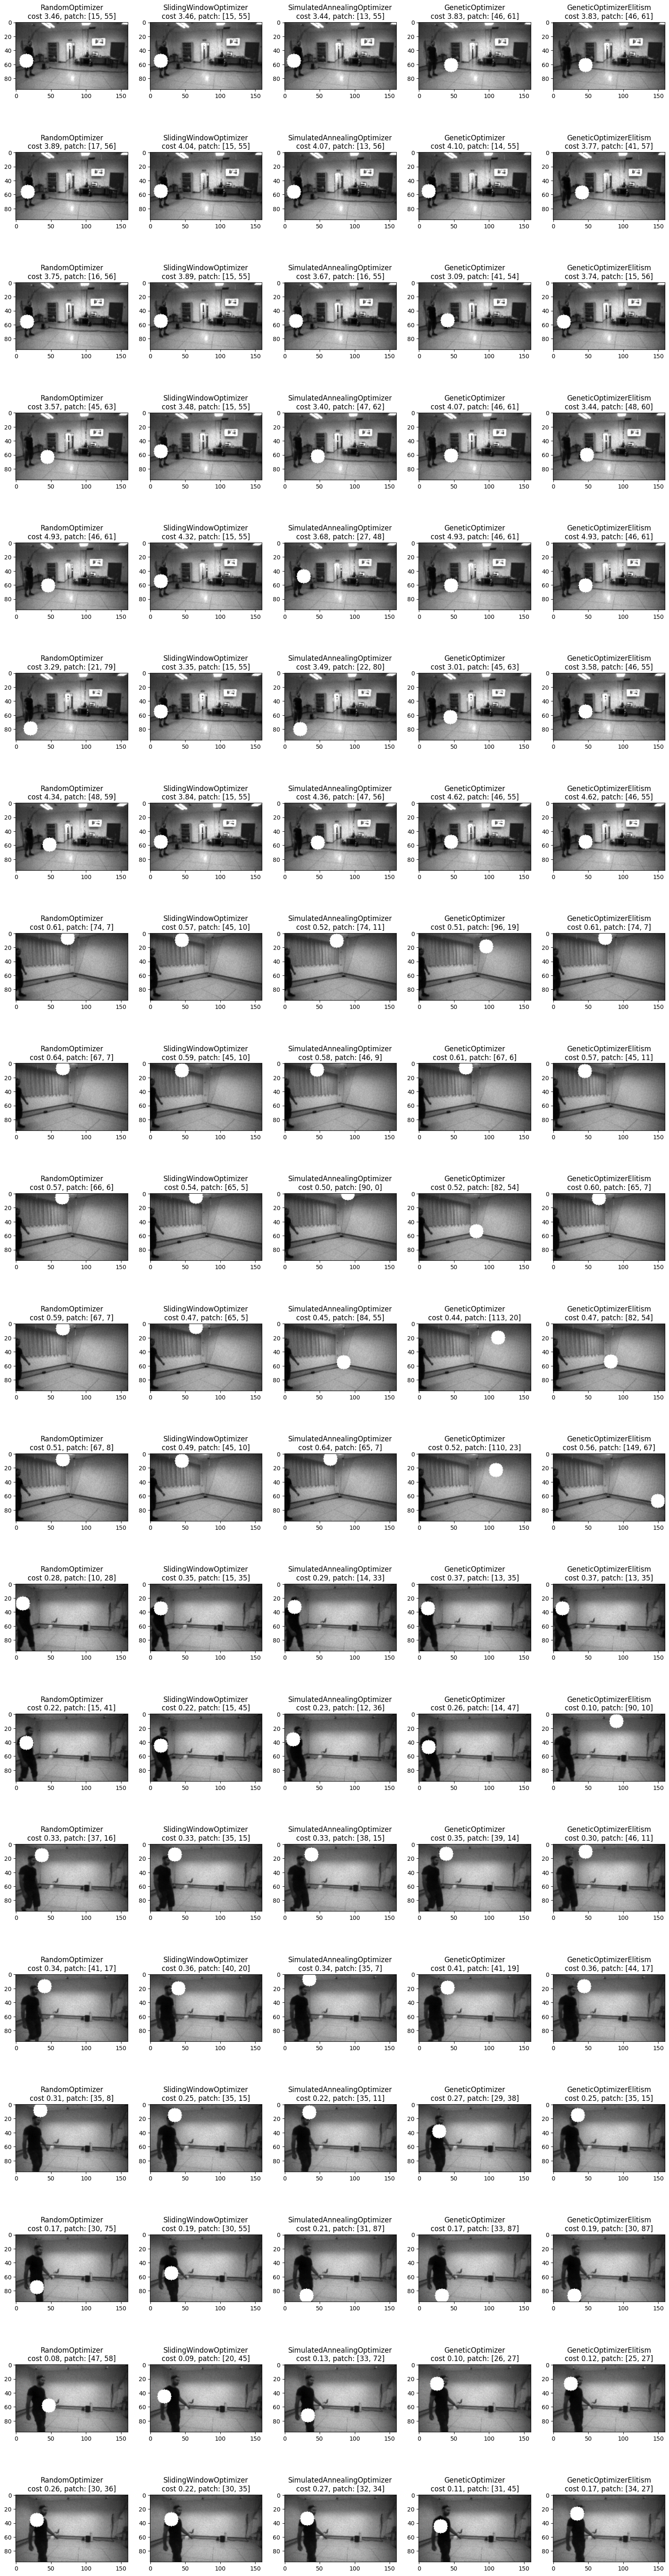

In [137]:
n_rows = 20
n_cols = len(optimizer_names)

from_id = 10
to_id = from_id + n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 80))

row_id = 0
for i in tqdm(range(from_id, to_id), desc="Checking patches", total=len(test_set)):
    x, y = test_set[i]
    results = db.search(User.image_idx == i)[0]
    for j, optimizer_name in enumerate(optimizer_names):
        if optimizer_name == "GeneticOptimizerElitism":
            results = genetic_elitism_db.search(User.image_idx == i)[0]  
        else:
            results = db.search(User.image_idx == i)[0]  
        
        best_cost: float = results[optimizer_name][0]
        best_patch: Tuple[int, int] = results[optimizer_name][1]
        
        img_copy = x.numpy().copy()[0]
        apply_path(
            img=img_copy,
            x=best_patch[0],
            y=best_patch[1],
            size=10,
        )
        axes[row_id][j].imshow(img_copy, cmap="gray")
        axes[row_id][j].set_title(f"{optimizer_name}\ncost {best_cost:.2f}, patch: {best_patch}")
    row_id += 1

In [145]:
all_costs = {
    name: [] for name in optimizer_names 
}

for i in tqdm(range(len(test_set)), desc="Checking results", total=len(test_set)):
    x, y = test_set[i]  
    for j, optimizer_name in enumerate(optimizer_names):
        if optimizer_name == "GeneticOptimizerElitism":
            results = genetic_elitism_db.search(User.image_idx == i)[-1]  
        else:
            results = db.search(User.image_idx == i)[0]  
        
        best_cost: float = results[optimizer_name][0]
        best_patch: Tuple[int, int] = results[optimizer_name][1]
        all_costs[optimizer_name].append(best_cost)

Checking results:   3%|▎         | 130/4028 [00:09<04:41, 13.85it/s]


KeyboardInterrupt: 

In [62]:
all_costs["SimulatedAnnealingOptimizer"] = [x for x in all_costs["SimulatedAnnealingOptimizer"] if x >= 0]

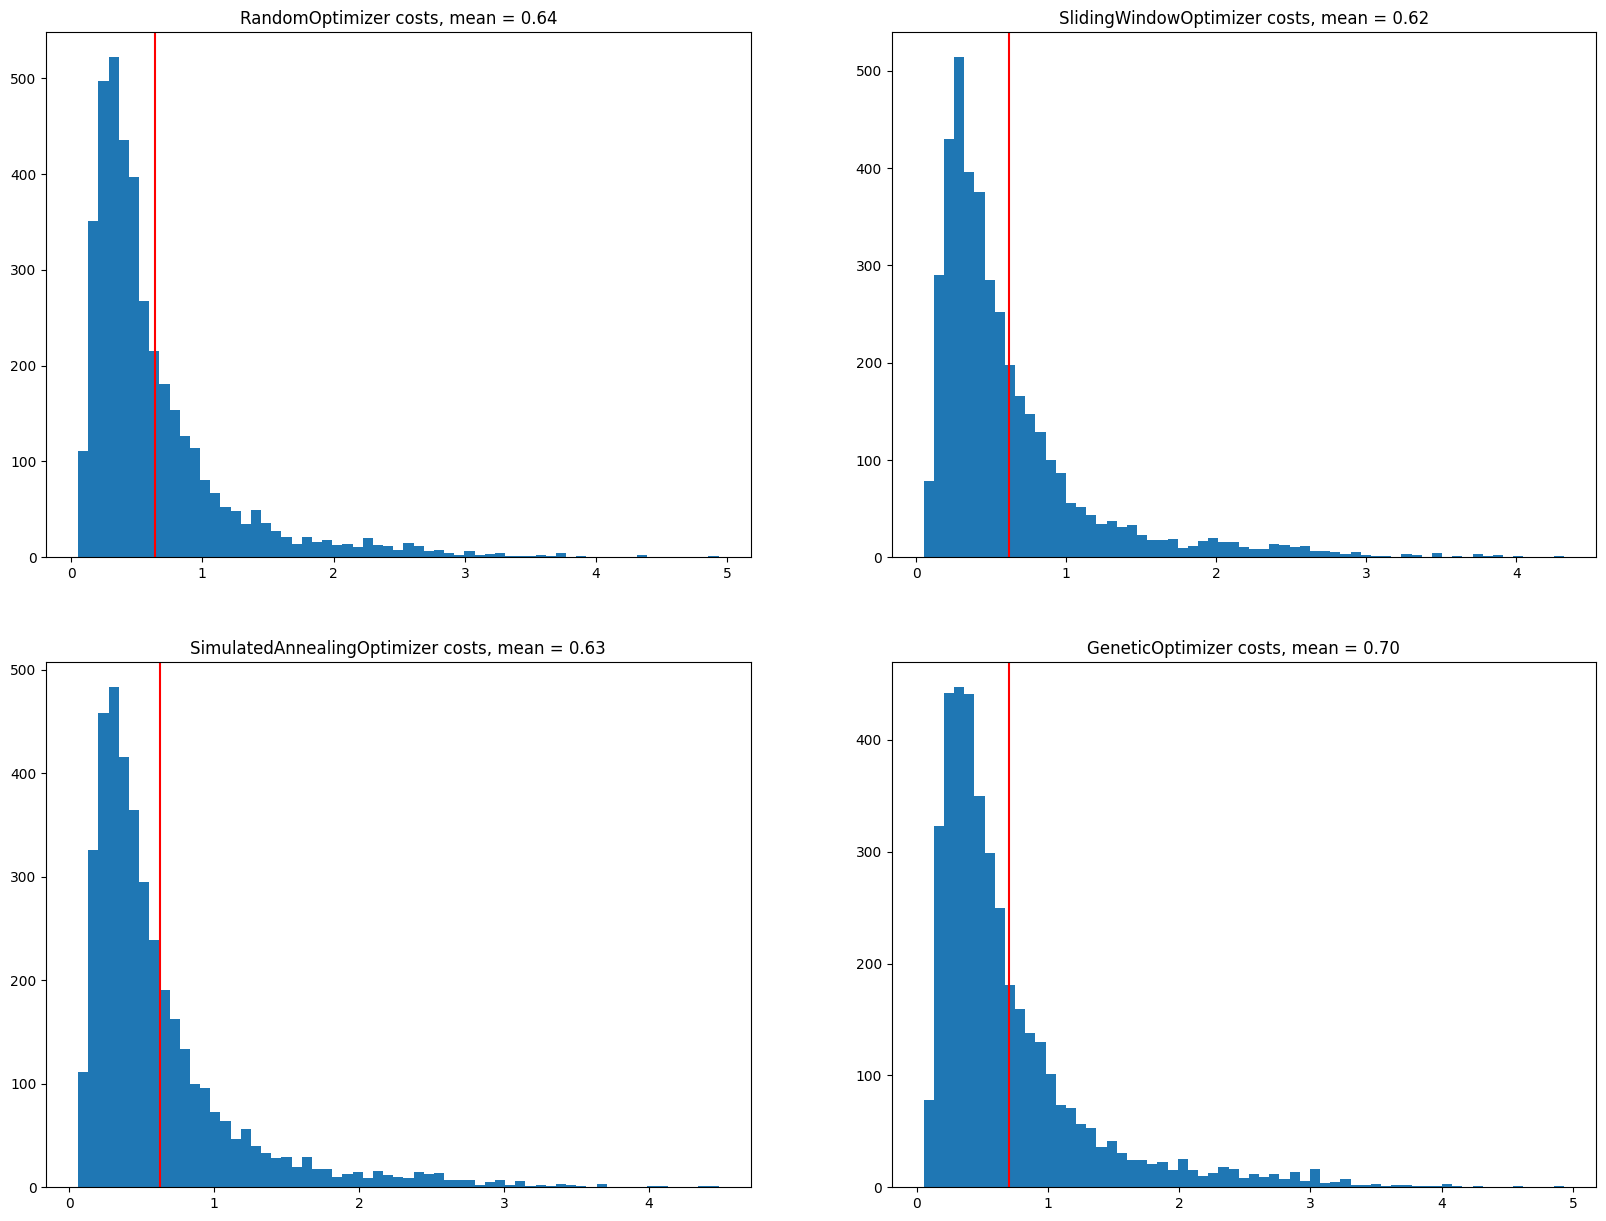

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, optimizer_name in enumerate(
    ("RandomOptimizer", "SlidingWindowOptimizer", "SimulatedAnnealingOptimizer", "GeneticOptimizer")
):
    axes[i // 2][i % 2].hist(
        all_costs[optimizer_name], 
        bins=int(np.sqrt(len(test_set))),
    )
    mean_cost = np.mean(all_costs[optimizer_name])
    axes[i // 2][i % 2].axvline(mean_cost, c="red")
    axes[i // 2][i % 2].set_title(f"{optimizer_name} costs, mean = {mean_cost:.2f}")

## Untargeted attack on y coordinate

In [121]:
optimizer_names

['RandomOptimizer',
 'SlidingWindowOptimizer',
 'SimulatedAnnealingOptimizer',
 'GeneticOptimizer',
 'GeneticOptimizerElitism']

Plotting patches: 100%|██████████| 20/20 [00:02<00:00,  9.46it/s]


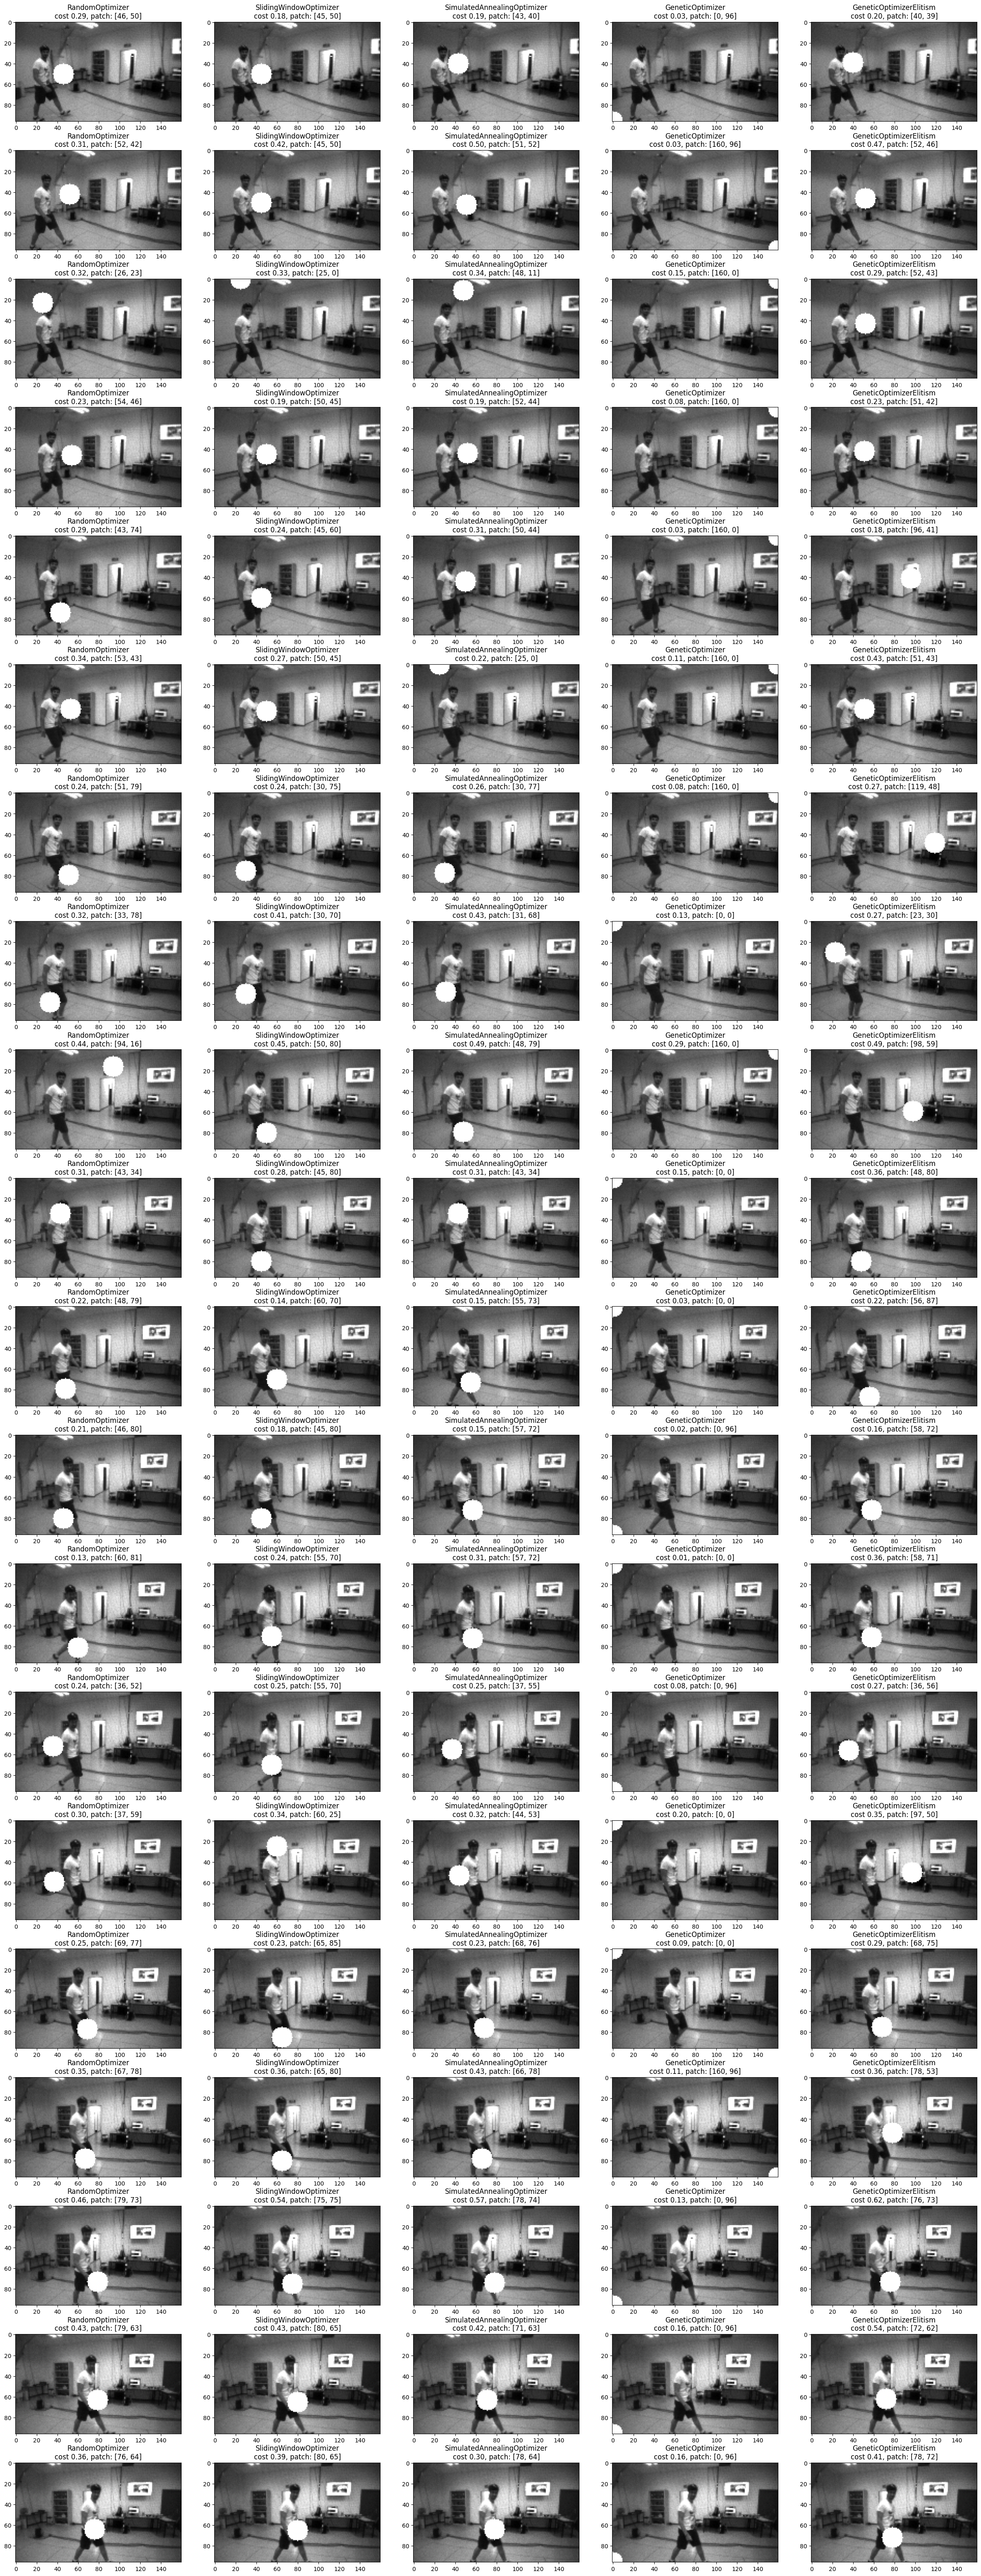

In [129]:
dbs = [
    TinyDB("random_y.json"),
    TinyDB("sliding_y.json"),
    TinyDB("annealing_y.json"),
    TinyDB("genetic_y.json"),
    TinyDB("genetic_elitism_y.json"),
]

n_rows = 20
n_cols = len(dbs)

from_id = 1000
to_id = from_id + n_rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 80))

row_id = 0
for i in tqdm(range(from_id, to_id), desc="Plotting patches", total=to_id - from_id):
    x, y = test_set[i]
    for j, optimizer_name in enumerate(optimizer_names):
        if optimizer_name == "SimulatedAnnealingOptimizer":
            results = dbs[j].search(User.image_idx == i)[0]  
            optimizer_name_adjusted = list(results.keys())[1]
            best_cost: float = results[optimizer_name_adjusted][0]
            best_patch: Tuple[int, int] = results[optimizer_name_adjusted][1]
        else:
            results = dbs[j].search(User.image_idx == i)[0]  
            best_cost: float = results[optimizer_name][0]
            best_patch: Tuple[int, int] = results[optimizer_name][1]
        
        img_copy = x.numpy().copy()[0]
        apply_path(
            img=img_copy,
            x=best_patch[0],
            y=best_patch[1],
            size=10,
        )
        axes[row_id][j].imshow(img_copy, cmap="gray")
        axes[row_id][j].set_title(f"{optimizer_name}\ncost {best_cost:.2f}, patch: {best_patch}")
    row_id += 1

In [131]:
all_costs_y = {
    name: [] for name in optimizer_names 
}

for i in tqdm(range(len(test_set)), desc="Checking results", total=len(test_set)):
    x, y = test_set[i]  
    for j, optimizer_name in enumerate(optimizer_names):
        results = dbs[j].search(User.image_idx == i)[0]  
        if optimizer_name == "SimulatedAnnealingOptimizer":
            optimizer_name_adjusted = list(results.keys())[1]
            best_cost: float = results[optimizer_name_adjusted][0]
            best_patch: Tuple[int, int] = results[optimizer_name_adjusted][1]
        else:
            best_cost: float = results[optimizer_name][0]
            best_patch: Tuple[int, int] = results[optimizer_name][1]
            
        all_costs_y[optimizer_name].append(best_cost)

Checking results: 100%|██████████| 4028/4028 [07:13<00:00,  9.30it/s]


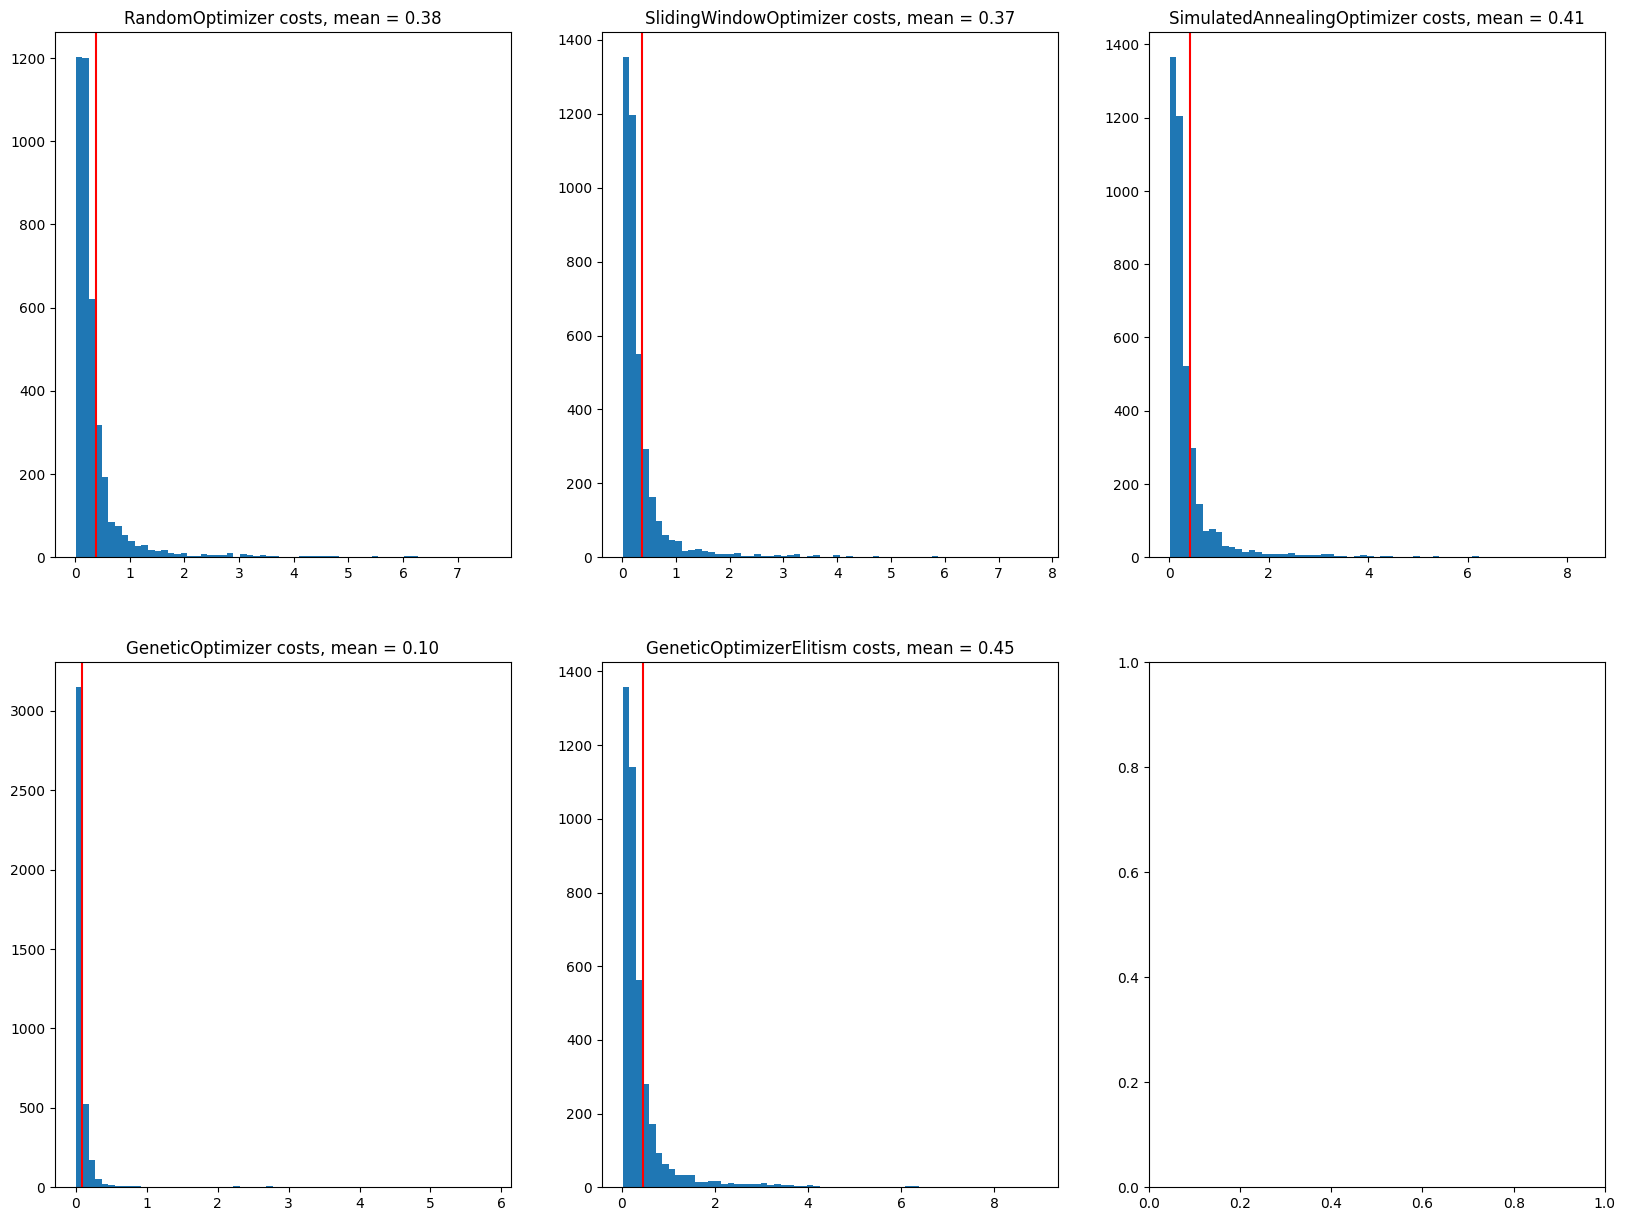

In [132]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

for i, optimizer_name in enumerate(optimizer_names):
    axes[i // 3][i % 3].hist(
        all_costs_y[optimizer_name], 
        bins=int(np.sqrt(len(test_set))),
    )
    mean_cost = np.mean(all_costs_y[optimizer_name])
    axes[i // 3][i % 3].axvline(mean_cost, c="red")
    axes[i // 3][i % 3].set_title(f"{optimizer_name} costs, mean = {mean_cost:.2f}")

## Untargeted attack on z coordinate